# Progseq

In their nature paper Cell simulation as cell segmentation the authors published a method called Proseg (probabilistic segmentation), to rapidly infer morphologically plausible cell boundaries. Their benchmarking pipeline could be used for similar pourpose as we intend. Here we try to recreate the pipelines. The original code is provided in julia here https://github.com/dcjones/SpuriousCoexpression.jl/tree/main.
This script aims to reproduce the score and obtain it for various methods based on the Visium post Xenium dataset.
We will use again dataset on lung cancer tissue

use the tmp_enact_analysis environment

The first part works by taking prior nuclear segmentation (which we assume has low rates of spurious coexpression), and comparing it to nuclear expansion segmentation (which we assume has high rates of spurious coexpression). Genes that show dramatically higher rates of coexpression in nuclear expansion are considered a spurious pair.

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata

In [114]:
output_path_nuclei = "/srv/gstore/projects/p1001/EzPyzENACTApp_2025-06-17--15-19-02/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2"
output_path_cells = "/srv/gstore/projects/p1001/EzPyzENACTApp_2025-05-14--11-40-13/ENACTApp_Visium_HD_Human_Lung_Cancer_post_Xenium_5K_Experiment2"
# Anndata object path
nuclei_adata_path = f"{output_path_nuclei}/tmap/weighted_by_area|celltypist_cells_adata.h5"
cells_adata_path = f"{output_path_cells}/tmap/weighted_by_area|celltypist_cells_adata.h5"


In [115]:
# Loading Anndata object
adata_cells = sc.read_h5ad(cells_adata_path)
adata_cells

AnnData object with n_obs × n_vars = 188596 × 18085
    obs: 'cell_type', 'patch_id'
    obsm: 'spatial', 'stats'

In [116]:
# Loading Anndata object
adata_nuclei = sc.read_h5ad(nuclei_adata_path)
adata_nuclei

AnnData object with n_obs × n_vars = 188423 × 18085
    obs: 'cell_type', 'patch_id'
    obsm: 'spatial', 'stats'

Make sure they correspond to each other

In [117]:
# Ensure both have the same index order
common_ids = adata_cells.obs_names.intersection(adata_nuclei.obs_names)
spatial_cells = adata_cells.obsm['spatial'].loc[common_ids].values
spatial_nuclei = adata_nuclei.obsm['spatial'].loc[common_ids].values

# Calculate Euclidean distances
distances = np.linalg.norm(spatial_cells - spatial_nuclei, axis=1)

# Report
n_mismatch = np.sum(distances > 1e-6)
avg_distance = np.mean(distances)

print(f"Number of cells/nuclei with mismatched coordinates: {n_mismatch} out of {len(common_ids)}")
print(f"Average distance between matched coordinates: {avg_distance:.4f}")

# Filter AnnData objects to only include common_ids
adata_cells = adata_cells[common_ids].copy()
adata_nuclei = adata_nuclei[common_ids].copy()

Number of cells/nuclei with mismatched coordinates: 0 out of 188416
Average distance between matched coordinates: 0.0000


In [118]:
sc.pp.calculate_qc_metrics(adata_cells, inplace=True)
sc.pp.calculate_qc_metrics(adata_nuclei, inplace=True)

print("Quality control metrics for cells:")
print(adata_cells.obs[['total_counts', 'n_genes_by_counts']].describe())
print("Quality control metrics for nuclei:")
print(adata_nuclei.obs[['total_counts', 'n_genes_by_counts']].describe())

Quality control metrics for cells:
        total_counts  n_genes_by_counts
count  188416.000000      188416.000000
mean      148.263947         141.785905
std       149.431503         134.678419
min         0.000000           0.000000
25%        50.643202          50.000000
50%        94.752220          93.000000
75%       192.301300         189.000000
max      2117.144287        1927.000000
Quality control metrics for nuclei:
        total_counts  n_genes_by_counts
count  188416.000000      188416.000000
mean       78.091743          63.250048
std        90.764244          73.924198
min         0.000000           0.000000
25%        19.888497          16.000000
50%        46.177538          37.000000
75%        99.758438          80.000000
max      1274.255005        1063.000000


In [119]:

total_counts_cells = np.array(adata_cells.X.sum(axis=1)).flatten()
cell_mask_50 = total_counts_cells >= 50
filtered_ids = adata_cells.obs_names[cell_mask_50]
# Use mean_counts from AnnData var to get indices of top 1000 genes
mean_counts = adata_cells.var["mean_counts"].values
top_1000_idx = np.argsort(mean_counts)[-1000:]
# only keep the first 10000 cells for memory efficiency
adata_cells_selected = adata_cells[filtered_ids[:10000], top_1000_idx].copy()
adata_nuclei_selected = adata_nuclei[filtered_ids[:10000], top_1000_idx].copy()

print(f"Cells remaining after filtering for >50 transcripts: {len(filtered_ids)}")
adata_cells_selected

Cells remaining after filtering for >50 transcripts: 142110


AnnData object with n_obs × n_vars = 10000 × 1000
    obs: 'cell_type', 'patch_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial', 'stats'

In [120]:
# Filter AnnData objects to only include cells where the nucleus has at least 2 total counts
# Recompute total counts for each nucleus
total_counts_nuc = np.array(adata_nuclei_selected.X.sum(axis=1)).flatten()
nuc_mask = total_counts_nuc >= 2
excluded_cells = np.sum(~nuc_mask)
print(f"Number of excluded cells/nuclei (nucleus < 2 counts): {excluded_cells}")
# Exclude genes not expressed in at least two nuclei
gene_mask = (adata_nuclei_selected.X > 0).sum(axis=0) >= 2
if hasattr(gene_mask, "A1"):  # handle sparse matrix
    gene_mask = gene_mask.A1
excluded_genes = np.sum(~gene_mask)
print(f"Number of excluded genes (expressed in <2 nuclei): {excluded_genes}")
adata_cells_ready = adata_cells_selected[nuc_mask, gene_mask].copy()
adata_nuclei_ready = adata_nuclei_selected[nuc_mask, gene_mask].copy()

Number of excluded cells/nuclei (nucleus < 2 counts): 24
Number of excluded genes (expressed in <2 nuclei): 0


In [121]:

# Check for floating point precision issues in multinomial_downsample
def safe_multinomial_downsample(cdata):
    X = cdata.X.toarray() 
    X_ds = np.zeros_like(X, dtype=int)
    for i in range(X.shape[0]):
        counts = X[i]
        total = counts.sum()
        if total > 1:
            probs = counts / total
            # Normalize to sum to 1.0
            if probs.sum() > 0:
                probs = probs.astype(np.float64)  # Cast to 64-bit float
                probs = probs / probs.sum()
                if probs.sum() > 1.05 or probs.sum() < 0.95:
                   print(i)
                X_ds[i] = np.random.multinomial(50, probs, size=1).flatten()
            else:
                print(f"Warning: Row {i} has zero total counts, skipping downsampling.")
        else:
            print(f"Warning: Row {i} has total counts {counts.sum()}<= 1, skipping downsampling.")
    return X_ds

cell_X_ds = safe_multinomial_downsample(adata_cells_ready)
nuclei_X_ds = safe_multinomial_downsample(adata_nuclei_ready)

# Create new AnnData objects with downsampled counts
adata_cells_resampled = anndata.AnnData(cell_X_ds, obs=adata_cells_ready.obs.copy(), var=adata_cells_ready.var.copy())
adata_nuclei_resampled = anndata.AnnData(nuclei_X_ds, obs=adata_nuclei_ready.obs.copy(), var=adata_nuclei_ready.var.copy())

In [122]:
print("Binarizing expression matrix (cell_X_ds > 0)...")
expr = (cell_X_ds > 0).astype(int)

print("Calculating coexpression matrix using matrix multiplication...")
coexpr_matrix = (expr.T @ expr) / np.sum(expr, axis=0)

# Zero out diagonal to ignore self-coexpression
coexpr_no_diag = coexpr_matrix.copy()
np.fill_diagonal(coexpr_no_diag, 0)

# Find the indices of the top N coexpressed gene pairs
N = 10
flat_indices = np.argpartition(coexpr_no_diag.flatten(), -N)[-N:]
row_idx, col_idx = np.unravel_index(flat_indices, coexpr_no_diag.shape)

# Get gene names
gene_names = adata_cells.var_names

# List the most coexpressed gene pairs and their counts
top_pairs = []
for i, j in zip(row_idx, col_idx):
    top_pairs.append((gene_names[i], gene_names[j], coexpr_no_diag[i, j]))

# Sort by coexpression count descending
top_pairs = sorted(top_pairs, key=lambda x: -x[2])

for g1, g2, count in top_pairs:
    print(f"{g1} - {g2}: {count}")

Binarizing expression matrix (cell_X_ds > 0)...
Calculating coexpression matrix using matrix multiplication...
PDZK1 - TSHB: 0.952063914780293
PDZK1 - PHGDH: 0.9466992665036675
PDZK1 - EPHX4: 0.9404761904761905
PDZK1 - SLC16A4: 0.9262981574539364
NBPF20 - EPHX4: 0.9196428571428571
PDZK1 - NBPF20: 0.9048167338322779
PDZK1 - CD101: 0.9004037685060565
PDZK1 - KANK4: 0.8982035928143712
PDZK1 - AK4: 0.8883248730964467
PDZK1 - GBP3: 0.8758620689655172


In [56]:
expr[0,:].sum() # after downsampling, the first cell has 50 counts but likely multiple on the same gene so binarization will lead to gene expression in fewer genes

41

In [123]:
print("Binarizing expression matrix (nuc_expr > 0)...")
expr_nuc = (nuclei_X_ds> 0).astype(int)

print("Calculating coexpression matrix using matrix multiplication...")
coexpr_matrix_nuc = (expr_nuc.T @ expr_nuc) / np.sum(expr_nuc, axis=0)

# Zero out diagonal to ignore self-coexpression
# If coexpr_matrix_nuc is a COOrdinate sparse matrix, convert to dense numpy array
if hasattr(coexpr_matrix_nuc, "tocoo"):
    coexpr_no_diag_nuc = coexpr_matrix_nuc.toarray()
else:
    coexpr_no_diag_nuc = coexpr_matrix_nuc.copy()
np.fill_diagonal(coexpr_no_diag_nuc, 0)

coexpr_matrix_nuc_res = coexpr_no_diag_nuc.copy()
# Find the indices of the top N coexpressed gene pairs
N = 10
flat_indices = np.argpartition(coexpr_matrix_nuc_res.flatten(), -N)[-N:]
row_idx, col_idx = np.unravel_index(flat_indices, coexpr_matrix_nuc_res.shape)

# Get gene names
gene_names = adata_nuclei.var_names

# List the most coexpressed gene pairs and their counts
top_pairs = []
for i, j in zip(row_idx, col_idx):
    top_pairs.append((gene_names[i], gene_names[j], coexpr_matrix_nuc_res[i, j]))

# Sort by coexpression count descending
top_pairs = sorted(top_pairs, key=lambda x: -x[2])

for g1, g2, count in top_pairs:
    print(f"{g1} - {g2}: {count}")

Binarizing expression matrix (nuc_expr > 0)...
Calculating coexpression matrix using matrix multiplication...
PALMD - GFI1: 1.0
NRAS - GFI1: 1.0
TLCD4 - GFI1: 1.0
COA7 - GFI1: 1.0
PGM1 - GFI1: 1.0
AHDC1 - GFI1: 1.0
WARS2 - GFI1: 1.0
SPAG17 - GFI1: 1.0
LSM10 - GFI1: 1.0
FCGR1B - GFI1: 1.0


In [124]:
# Avoid division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    rel_increase_res = coexpr_no_diag / np.where(coexpr_matrix_nuc_res > 0, coexpr_matrix_nuc_res, 1)

# Find pairs with >50% increase in coexpression in cells vs nuclei
spurious_mask = rel_increase_res > 1.5

# Get indices of such pairs
spurious_row, spurious_col = np.where(spurious_mask)

# List the pairs 
spurious_pairs = []
for i, j in zip(spurious_row, spurious_col):
    spurious_pairs.append((gene_names[i], gene_names[j], coexpr_no_diag[i, j], coexpr_no_diag_nuc[i, j], rel_increase_res[i, j]))

print(f"Number of potentially spurious pairs: {len(spurious_pairs)}")
# Show top 10 by relative increase
spurious_pairs_sorted = sorted(spurious_pairs, key=lambda x: -x[4])
for g1, g2, cell_val, nuc_val, rel_inc in spurious_pairs_sorted[:10]:
    print(f"{g1} - {g2}: cell={cell_val}, nuclei={nuc_val}, rel_increase={rel_inc:.2f}")

Number of potentially spurious pairs: 236020
MOV10 - PADI1: cell=0.20238095238095238, nuclei=0.013513513513513514, rel_increase=14.98
IQCC - CASQ2: cell=0.022085889570552148, nuclei=0.0015432098765432098, rel_increase=14.31
PRMT6 - SARS: cell=0.0621301775147929, nuclei=0.0043859649122807015, rel_increase=14.17
SARS - PRMT6: cell=0.05555555555555555, nuclei=0.003937007874015748, rel_increase=14.11
ZNF683 - MOB3C: cell=0.07423580786026202, nuclei=0.005291005291005291, rel_increase=14.03
TSPAN2 - LIN28A: cell=0.1619047619047619, nuclei=0.011627906976744186, rel_increase=13.92
TSPAN2 - TRIM45: cell=0.15789473684210525, nuclei=0.011363636363636364, rel_increase=13.89
E2F2 - HAO2: cell=0.01282051282051282, nuclei=0.000946073793755913, rel_increase=13.55
H6PD - VANGL1: cell=0.018199233716475097, nuclei=0.0013550135501355014, rel_increase=13.43
EPS8L3 - JAK1: cell=0.06153846153846154, nuclei=0.004608294930875576, rel_increase=13.35


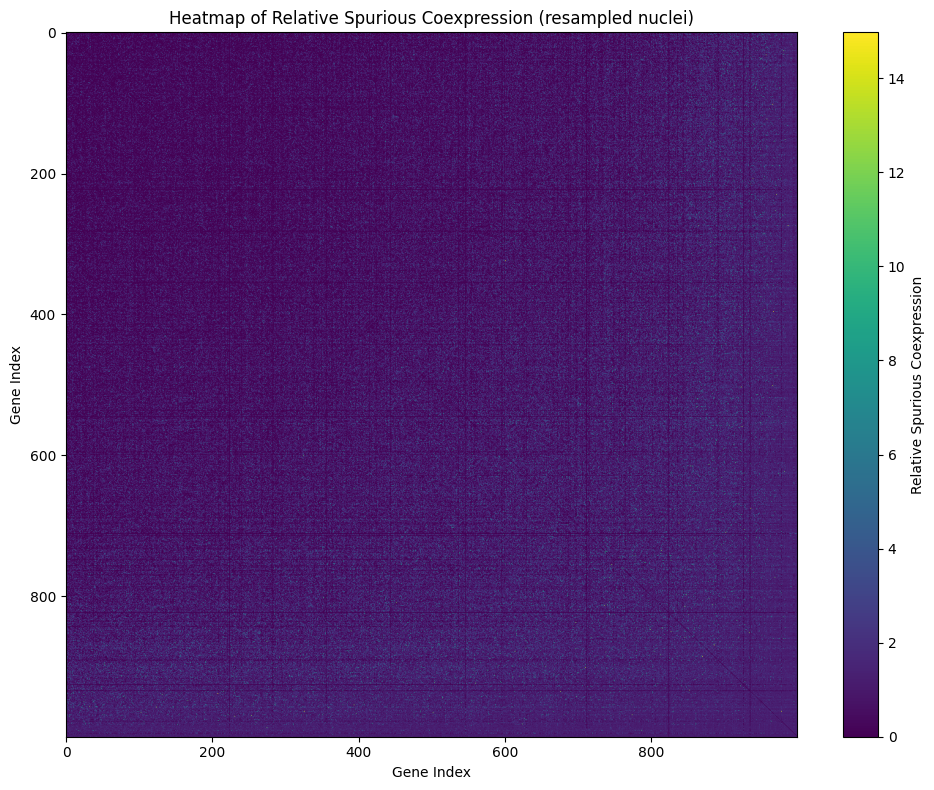

In [125]:
plt.figure(figsize=(10, 8))
plt.imshow(rel_increase_res, aspect='auto', cmap='viridis')
plt.colorbar(label='Relative Spurious Coexpression')
plt.title('Heatmap of Relative Spurious Coexpression (resampled nuclei)')
plt.xlabel('Gene Index')
plt.ylabel('Gene Index')
plt.tight_layout()
plt.show()

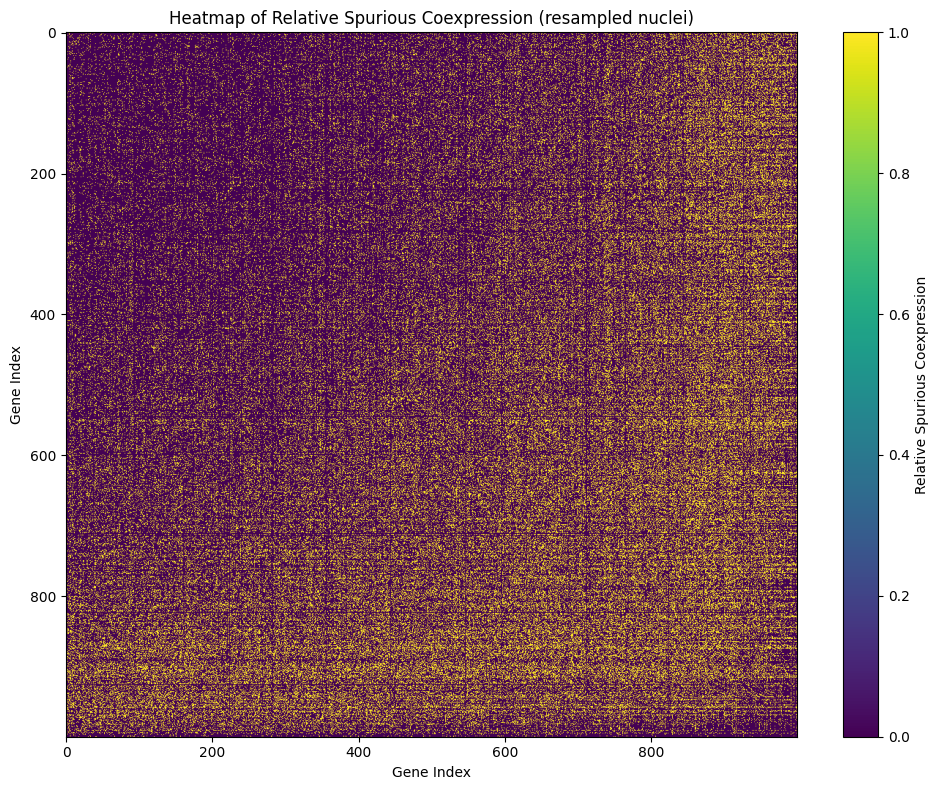

In [126]:
plt.figure(figsize=(10, 8))
plt.imshow(spurious_mask , aspect='auto', cmap='viridis')
plt.colorbar(label='Relative Spurious Coexpression')
plt.title('Heatmap of Relative Spurious Coexpression (resampled nuclei)')
plt.xlabel('Gene Index')
plt.ylabel('Gene Index')
plt.tight_layout()
plt.show()

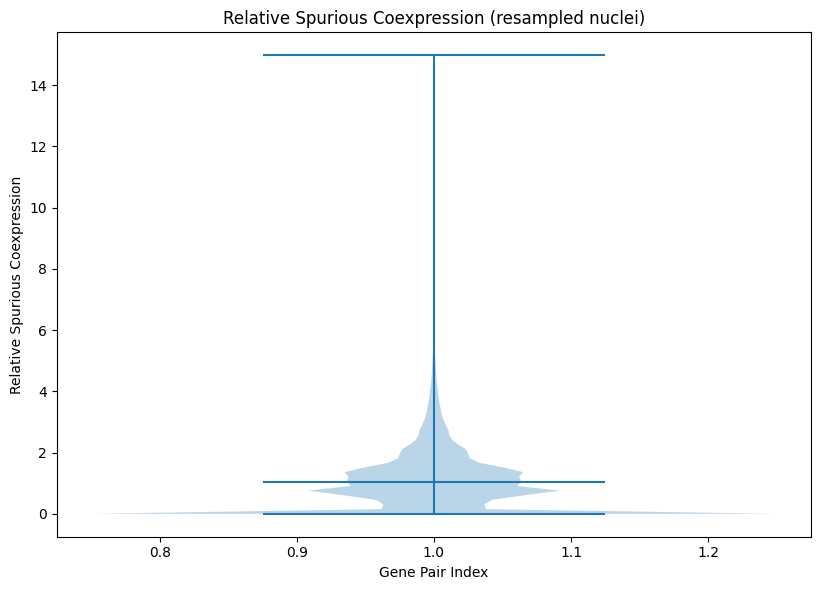

In [ ]:
plt.figure(figsize=(16, 6))


plt.violinplot(rel_increase_res.flatten(), showmeans=True)
plt.title("Relative Spurious Coexpression (resampled nuclei)")
plt.ylabel("Relative Spurious Coexpression")
plt.xlabel("Gene Pair Index")

plt.tight_layout()
plt.show()

In [128]:
# Report statistic summary for rel_increase_res and rel_increase_nores
def summary_stats(arr, name):
    print(f"Summary statistics for {name}:")
    print(f"  Mean: {np.mean(arr):.3f}")
    print(f"  Median: {np.median(arr):.3f}")
    print(f"  Std: {np.std(arr):.3f}")
    print(f"  Min: {np.min(arr):.3f}")
    print(f"  Max: {np.max(arr):.3f}")
    print()

summary_stats(rel_increase_res, "rel_increase_res")

Summary statistics for rel_increase_res:
  Mean: 1.024
  Median: 0.822
  Std: 1.037
  Min: 0.000
  Max: 14.976



In [20]:
import pandas as pd

# Convert spurious_pairs_sorted to DataFrame
spurious_df = pd.DataFrame(spurious_pairs_sorted, columns=[
    "Gene1", "Gene2", "Cell_Coexpression", "Nuclei_Coexpression", "Relative_Increase"
])

# Save to CSV
spurious_df.to_csv("spurious_pairs_Enact.csv", index=False)
print("Spurious pairs data saved to spurious_pairs_Enact.csv")

Spurious pairs data saved to spurious_pairs_Enact.csv


In [129]:
# Save the coexpr_matrix_nuc_res numpy array to a file for later use
np.save("coexpr_matrix_nuc_res.npy", coexpr_matrix_nuc_res)
print("coexpr_matrix_nuc_res saved to coexpr_matrix_nuc_res.npy")

coexpr_matrix_nuc_res saved to coexpr_matrix_nuc_res.npy


In [130]:
# Save the spurious_mask numpy array to a file for later use
np.save("spurious_mask.npy", spurious_mask)
print("spurious_mask saved to spurious_mask.npy")

spurious_mask saved to spurious_mask.npy
